In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
section_detect = cv2.dnn.readNet('redes_entrenadas\custom-yolov4-detector.cfg','redes_entrenadas\custom-yolov4-detector_last.weights')

In [7]:
#traemos las clases
classes =[]
with open("redes_entrenadas\coco.names",'r') as f:
  classes=f.read().splitlines()

In [11]:
#3clases -3colores
colors = np.random.uniform(0, 255, size=(len(classes),3))

In [15]:
#funcion para cargar imagen
img=cv2.imread('prueba\C_324.jpg')
def Select(img):
    height, width = img.shape[:2]
    #Realizamos el acondicionamiento de la imagen para que entre a la red
    blob = cv2.dnn.blobFromImage(img, scalefactor = 1/255, size = (416, 416), mean= (0, 0, 0), swapRB = True, crop=False)
    section_detect.setInput(blob)
    output_layer_names=section_detect.getUnconnectedOutLayersNames() #obtiene la lista de las capas finales
    layerout=section_detect.forward(output_layer_names)#obtiene el valor de salida de las capas indicadas.

    #detecta las cajas totales,los indices que se usaran
    boxes =[]
    confidences=[]
    class_ids=[]

    for output in layerout:#entra en layerout
        for detection in output:
            score=detection[5:]
            class_id=np.argmax(score)#Identifica el score mas alto de la clase del objeto detectado mediante la máxima confianza
            confidence=score[class_id]
            if confidence>0.94:
                # El objeto es detectado
                center_x = int(detection[0] * width) #converting center_x with respect to original image size
                center_y = int(detection[1] * height)#converting center_y with respect to original image size
                w = int(detection[2] * width)#converting width with respect to original image size
                h = int(detection[3] * height)#converting height with respect to original image size

                x=int(center_x -w/2)
                y=int(center_y -h/2)
                boxes.append([x,y,w,h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                #no se repitan cajas
                indices=cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)
                index_sel=indices.flatten().tolist()
    return img,boxes,confidences,index_sel,class_ids

In [16]:
img,boxes,confidences,index_sel,class_ids= Select(img)

In [26]:
#recorta imagen
#podemos variar x,y,w,h  por si necesitamos ampliar la imagen o tomar los espacios debajo 
def recorta_bouding_boxes(img,boxes,confidences,nms_indexes,class_ids):
    for count, i in enumerate(nms_indexes):
        x, y, w, h = boxes[i]
        #recorte
        if class_ids[i]==0:
            fecha=img[y:y+h, x:x+w]
        if class_ids[i]==1:
            firma1=img[y:y+h, x:x+w]
        if class_ids[i]==2:
            firma2=img[y:y+h, x:x+w]
    return fecha,firma1,firma2

In [27]:
fecha,firma1,firma2 =recorta_bouding_boxes(img,boxes,confidences,index_sel,class_ids)

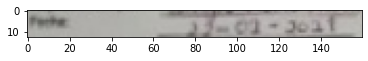

In [30]:
plt.imshow(cv2.cvtColor(fecha, cv2.COLOR_BGR2RGB))
plt.show()

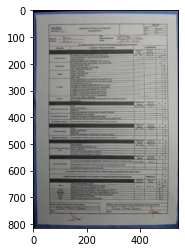

In [31]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

En esta ultima parte realizo el recorte solo para fecha,nota por cada set demorara aprox 120s

In [34]:
carpetaOrigen='imagenes_2lens_217' #carpeta de imagenes que seran recortadas
CarpetaDestino1='recorte_fecha' #carpeta origen para el recorte
list_files=os.listdir(carpetaOrigen)


for imagen in list_files:
    img = cv2.imread(carpetaOrigen + '/' + imagen)
    img,boxes,confidences,index_sel,class_ids= Select(img)
    fecha,firma1,firma2= recorta_bouding_boxes(img,boxes,confidences,index_sel,class_ids)
    cv2.imwrite(CarpetaDestino1 + '/' + imagen, fecha)
    #cv2.imwrite(CarpetaDestino2 + '/' + imagen, firma1)
    #cv2.imwrite(CarpetaDestino3 + '/' + imagen, firma2)